In [1]:
import numpy as np
import quaternion as qt
import library.ulogReader as ur
import library.quaternionUtils as qu
import library.choleskyDecomposition as cd
import library.quaternionVisualisation as qv

from pyulog import ULog

## Wczytanie danych lotu drona

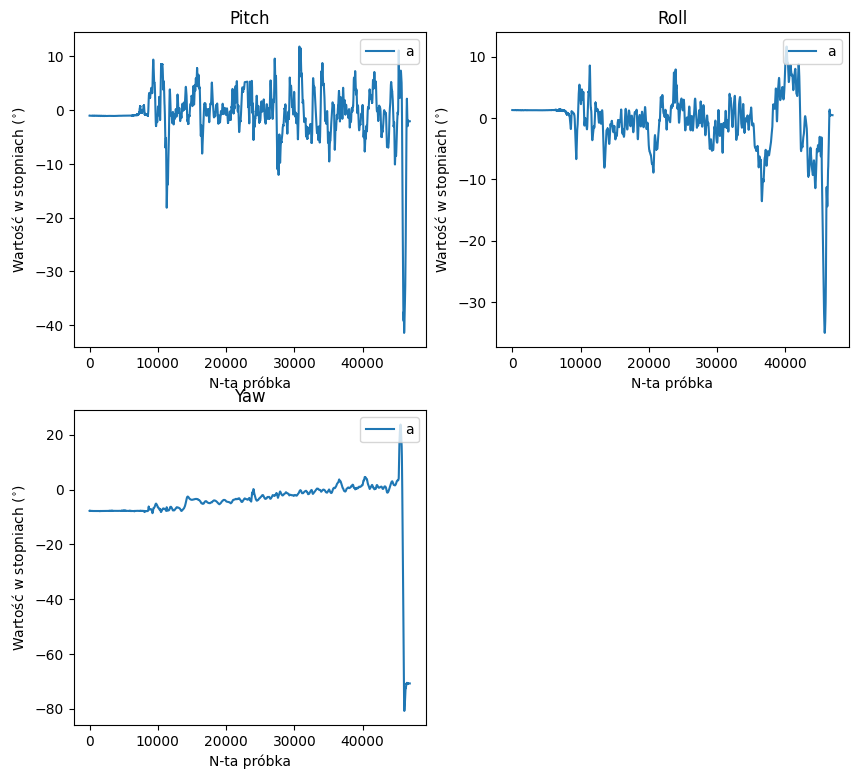

In [2]:
ulog_path = './ulogs/639_bs10_out_alt.ulg'
ulog = ULog(ulog_path)

attitude, attitude_time  = ur.readAttitude(ulog)
attitude_time = (attitude_time - attitude_time[0]) / 1e3

qv.display_quat_as_euler([attitude], [attitude_time], ['a'])


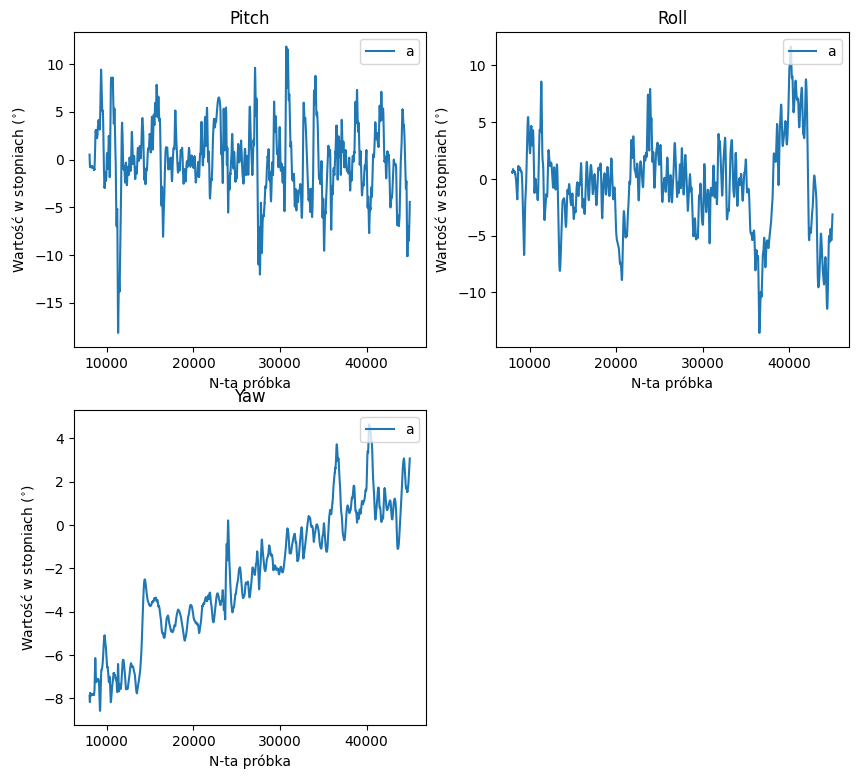

In [3]:
start_time = 8e3   
end_time   = 45e3

# Config interpolation
dt = 2      # Delta time in ms
degree = 3  # Spline degree

# Post resampling time
it_t = np.arange(start_time, end_time, dt)
attitude = qu.splineInterpolation(attitude, attitude_time, it_t, degree)
attitude_time = it_t

qv.display_quat_as_euler([attitude], [attitude_time], ['a'])

## Metoda Yule-Walkera
---  

In [4]:
def predictionKSteps(s: np.ndarray, w: np.ndarray, k_steps: int):
    for _ in range(k_steps):
        s[-1] = np.sum(w * s).normalized()
        s = np.roll(s, 1)
    
    return s[0]

In [44]:
# N_WINDOW = 10        # Custom version  (N_WINDOW > P_ORDER + 1)
P_ORDER    = 5 
K_FORECAST = [1,3,7]
N_WINDOW = 8
START_WINDOW = 30
MU = 1e-3

x = np.copy(attitude)[::2]
y = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

corr_matrix = qu.correlationMatrix(x[:START_WINDOW][::-1], P_ORDER + 1 , normalize=True)

for i in range(START_WINDOW, x.shape[0]+1):
    tmp_corr_matrix = qu.correlationMatrix(x[i-N_WINDOW : i][::-1], P_ORDER + 1, normalize=True)
    corr_matrix = (1-MU) * corr_matrix + MU * tmp_corr_matrix
    tmp_corr_matrix = np.copy(corr_matrix)
    np.fill_diagonal(tmp_corr_matrix, tmp_corr_matrix.diagonal()+qt.quaternion(1e-6,0,0,0))
    l = cd.choleskyDecomposition(tmp_corr_matrix[:-1, :-1])
    w = cd.solveLLHEquation(l, tmp_corr_matrix[1:,0])

    for k, k_steps in enumerate(K_FORECAST):
        y[k, i + k_steps - 1] = predictionKSteps(np.copy(x[i-P_ORDER : i][::-1]), w, k_steps)

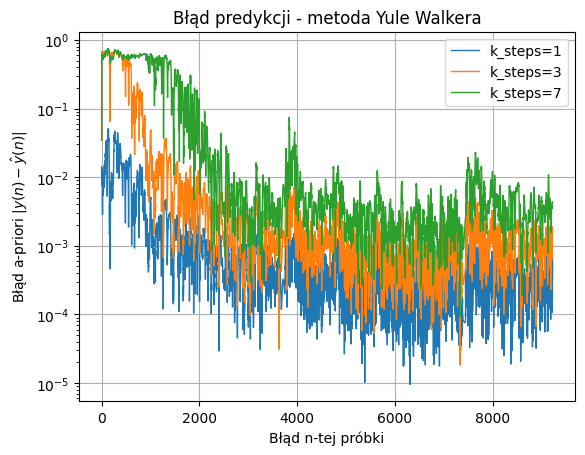

In [47]:
import matplotlib.pyplot as plt

for k, k_steps in enumerate(K_FORECAST):
    er_priori = quaternionError(y[k, START_WINDOW : x.shape[0]], x[START_WINDOW:])
    plt.plot(er_priori, linewidth=1, label='k_steps={}'.format(k_steps))
plt.title('Błąd predykcji - metoda Yule Walkera')
plt.xlabel('Błąd n-tej próbki')
plt.ylabel(r'Błąd a-priori $|y(n) - \hat y(n)|$')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()